<a href="https://colab.research.google.com/github/ShreyaAN10/LearnDeepLearning/blob/main/LinearNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create classification data

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

> X has `2 features`. y is either `0` or `1`

In [4]:
# make dataframe of circle data for better understanding

import pandas as pd

circles_df = pd.DataFrame({"X1" : X[:,0],
                          "X2" : X[:,1],
                          "label" : y})

circles_df

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


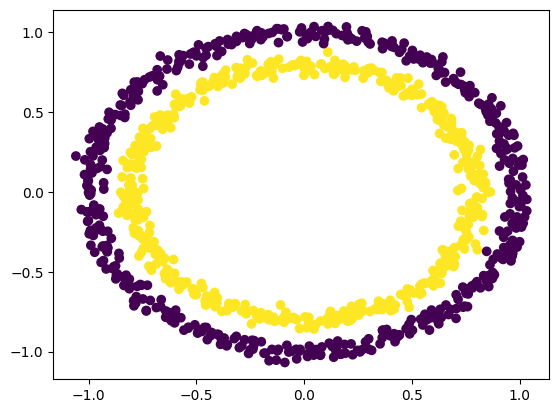

In [5]:
# visualize data

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y) # using 'y' implies different colors for different labels

> sklearn has more toy datasets. Look for sklearn toy datasets.

In [6]:
X.dtype, y.dtype

(dtype('float64'), dtype('int64'))

## Input and Output Shapes

In [7]:
print(f"One X sample looks like {X[0]}, and one y sample looks like {y[0]}")
print(f"One X sample is of the shape {X[0].shape}, and y sample is of {y[0].shape}")

One X sample looks like [0.75424625 0.23148074], and one y sample looks like 1
One X sample is of the shape (2,), and y sample is of ()


> this implies that the input shape of our NN must be 2 and the output shape must be 1

## Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.1.0+cu118'

In [9]:
X.dtype, y.dtype

(dtype('float64'), dtype('int64'))

> X is a tensor, but y is not. Let's convert it.

In [10]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
X.device, y.device

(device(type='cpu'), device(type='cpu'))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [13]:
len(X_train), len(y_train)

(800, 800)

## Modelling

1. setup device agnostic code
2. construct a model by subclassing `nn.Module`
3. Define a loss function and optimizer

In [14]:
import torch
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [15]:
class NeuralNet(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # create 2 nn.Linear layers
    self.layer1 = nn.Linear(in_features=2,
                            out_features=5) # takes 2 features and upscales to 5
    self.layer2 = nn.Linear(in_features=5,
                            out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer2(self.layer1(x)) # x -> layer1 -> layer2 -> output

# instantiate an instance of the model class and send it to target device
model0 = NeuralNet().to(device)
next(model0.parameters()).device


device(type='cuda', index=0)

In [16]:
# let's replicate the model above with nn.Sequential()
torch.manual_seed(42)
model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5, bias=True),
    nn.Linear(in_features=5, out_features=1, bias=True)
).to(device)

model1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('1.bias', tensor([-0.2060], device='cuda:0'))])

In [18]:
model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.1620,  0.2962],
                      [-0.0859,  0.4179],
                      [-0.4045,  0.0274],
                      [ 0.6996,  0.6756],
                      [-0.3879, -0.3055]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.6117,  0.4668, -0.4316, -0.6988,  0.3923], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.4233, -0.0119,  0.2878,  0.3988,  0.4136]], device='cuda:0')),
             ('layer2.bias', tensor([0.0936], device='cuda:0'))])

In [19]:
# make predictions
with torch.inference_mode():
  untrained_preds = model1(X_test.to(device))

print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"Length of untrained preds: {len(untrained_preds)}, Shape: {untrained_preds.shape}")

print(f"Actual labels: {y_test[:10]}")
print(f"Untrained predictions: {untrained_preds[:10]}")

Length of test samples: 200, Shape: torch.Size([200, 2])
Length of untrained preds: 200, Shape: torch.Size([200, 1])
Actual labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Untrained predictions: tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')


### Loss function, Optimizer and Evaluation Metrics

> how to choose the right loss function?
- for regression, use `MSE` or `MAE`
- for classification, use `binary cross entropy` or `categorical cross entropy(cross entropy)`

> for optimizers, 2 of the most common are `SGD` and `Adam`

In [20]:
# set up a loss function
# BCELoss() requires inputs to have gone through the sigmoid activation
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid activation built in

# set up an optmizer
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

# calculate evaluation metrics
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train Model

> going from raw logits -> prediction probabilities -> prediction labels
- our model outputs are going to be raw *logits*. We can convert these logits into *prediction preobabilities* by passing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert out model's predictions to *prediction labels* by either rounding them or taking the `argmax()`

In [21]:
# view first 5 outputs of the forward pass
y_logits = model1(X_test.to(device)[:5])
print(f"Logits: {y_logits}")

# prediction probabilities: use sigmoid activation on logits
y_pred_probs = torch.sigmoid(y_logits)
print(f"Prediction probabilities: {y_pred_probs}")

# for labels, we need to perform a range-style rounding on the probs
print(f"Labels: {torch.round(y_pred_probs)}")

Logits: tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0', grad_fn=<AddmmBackward0>)
Prediction probabilities: tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Labels: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)


### Building training and testing loops

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200
epoch_count = []
loss_values = []
accuracy_values = []

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # 1. training
  model1.train()

  # forward pass
  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # we're using BCEwithlogits which expects y_logits as input
  accuracy = accuracy_fn(y_train, y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # back prop
  loss.backward()

  # gradient descent
  optimizer.step()

  # 2. testing
  model1.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_test, test_pred)

  # print metrics
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | [Training] acc: {accuracy:.2f}, loss: {loss:.3f} | [Testing] acc: {test_accuracy:.2f}, loss: {test_loss:.3f}")
    epoch_count.append(epoch)
    loss_values.append(loss)
    accuracy_values.append(loss)

Epoch: 0 | [Training] acc: 50.00, loss: 0.696 | [Testing] acc: 50.00, loss: 0.697
Epoch: 10 | [Training] acc: 50.00, loss: 0.694 | [Testing] acc: 50.00, loss: 0.696
Epoch: 20 | [Training] acc: 46.00, loss: 0.693 | [Testing] acc: 48.50, loss: 0.696
Epoch: 30 | [Training] acc: 49.00, loss: 0.693 | [Testing] acc: 47.50, loss: 0.696
Epoch: 40 | [Training] acc: 49.50, loss: 0.693 | [Testing] acc: 46.50, loss: 0.696
Epoch: 50 | [Training] acc: 50.38, loss: 0.693 | [Testing] acc: 46.50, loss: 0.696
Epoch: 60 | [Training] acc: 50.50, loss: 0.693 | [Testing] acc: 46.50, loss: 0.696
Epoch: 70 | [Training] acc: 50.50, loss: 0.693 | [Testing] acc: 46.50, loss: 0.696
Epoch: 80 | [Training] acc: 50.75, loss: 0.693 | [Testing] acc: 46.50, loss: 0.696
Epoch: 90 | [Training] acc: 50.38, loss: 0.693 | [Testing] acc: 46.50, loss: 0.695
Epoch: 100 | [Training] acc: 50.50, loss: 0.693 | [Testing] acc: 46.50, loss: 0.695
Epoch: 110 | [Training] acc: 50.62, loss: 0.693 | [Testing] acc: 46.00, loss: 0.695
Epo

> model isn't learning. let's investigate

In [23]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo only if it doesn't already exist
if Path("helper_functions.py").is_file():
  print("exists")
else:
  print("Downloading...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Downloading...


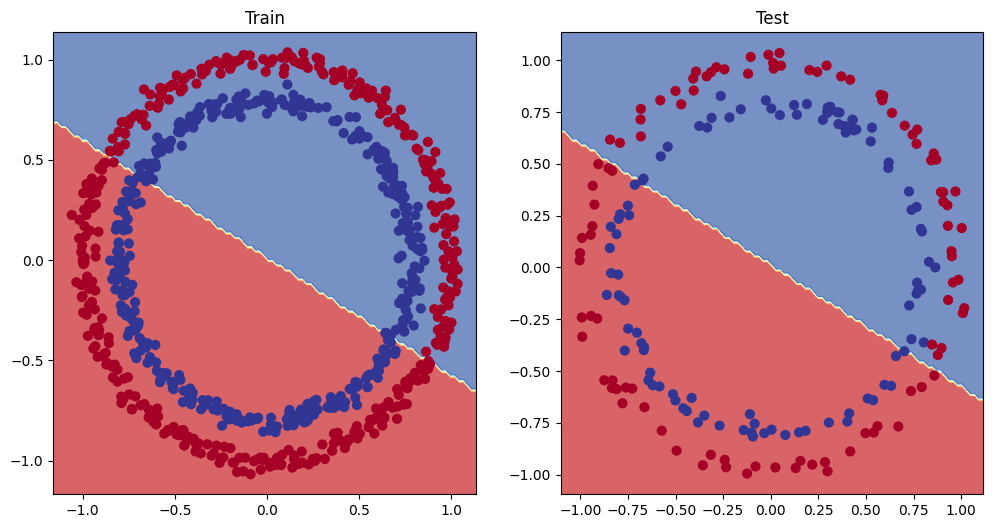

In [24]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

## Improving a model

- add more layers
- add more hidden units
- fit for longer
- change the activation function
- change the learning rate
- change the loss function

In [25]:
def accuracy_fn(true_labels, pred_labels):
  accuracy = ((torch.eq(true_labels, pred_labels).sum().item()) / len(true_labels)) * 100
  return accuracy


In [26]:
from sklearn.metrics import accuracy_score

class NeuralNet2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features= 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model2 = NeuralNet2().to(device)
model2.state_dict()
print(next(model2.parameters()).device)

# define loss and optimizer
new_loss_fn = nn.BCEWithLogitsLoss()
new_optimizer = torch.optim.Adam(params=model2.parameters(),
                                 lr=0.01)

# training

epochs = 100
epoch_values = []
loss_values = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model2.train()
    # forward
    y_logits = model2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = new_loss_fn(y_logits, y_train)

    accuracy = accuracy_fn(y_train, y_preds)

    new_optimizer.zero_grad()

    loss.backward()

    new_optimizer.step()

    # testing
    model2.eval()
    with torch.inference_mode():
      test_logits = model2(X_test).squeeze()
      test_preds = torch.round(torch.sigmoid(test_logits))
      test_accuracy = accuracy_fn(y_test, test_preds)
      test_loss = new_loss_fn(test_logits, y_test)

    # print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | [Training] acc: {accuracy:.2f}, loss: {loss:.3f} | [Testing] acc: {test_accuracy:.2f}, loss: {test_loss:.3f}")
      epoch_count.append(epoch)
      loss_values.append(loss)
      accuracy_values.append(loss)



cuda:0
Epoch: 0 | [Training] acc: 50.88, loss: 0.694 | [Testing] acc: 50.00, loss: 0.694
Epoch: 10 | [Training] acc: 49.50, loss: 0.693 | [Testing] acc: 46.50, loss: 0.694
Epoch: 20 | [Training] acc: 50.00, loss: 0.693 | [Testing] acc: 45.50, loss: 0.695
Epoch: 30 | [Training] acc: 50.12, loss: 0.693 | [Testing] acc: 46.50, loss: 0.695
Epoch: 40 | [Training] acc: 51.00, loss: 0.693 | [Testing] acc: 45.00, loss: 0.695
Epoch: 50 | [Training] acc: 51.00, loss: 0.693 | [Testing] acc: 45.00, loss: 0.695
Epoch: 60 | [Training] acc: 51.38, loss: 0.693 | [Testing] acc: 45.50, loss: 0.695
Epoch: 70 | [Training] acc: 51.38, loss: 0.693 | [Testing] acc: 46.00, loss: 0.695
Epoch: 80 | [Training] acc: 51.38, loss: 0.693 | [Testing] acc: 45.50, loss: 0.695
Epoch: 90 | [Training] acc: 51.25, loss: 0.693 | [Testing] acc: 45.50, loss: 0.695


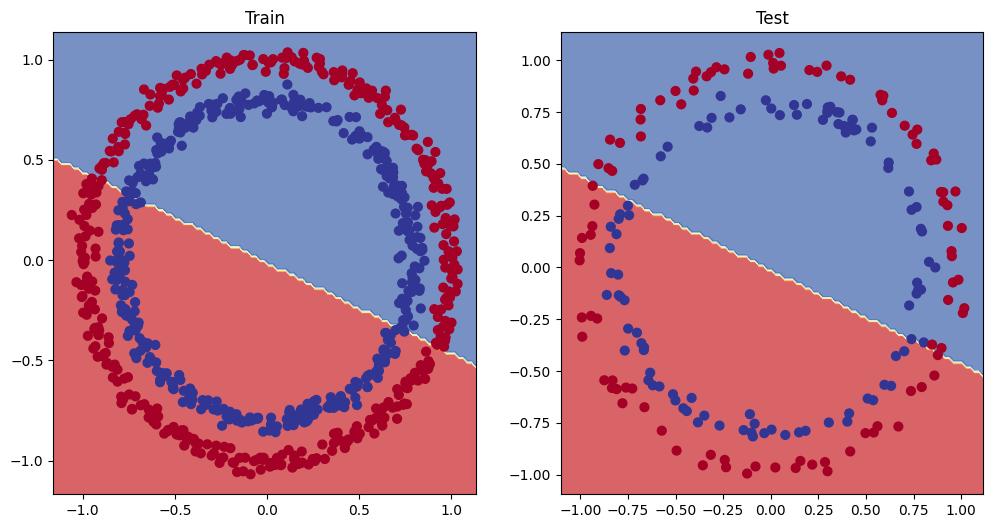

In [27]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

Looks like the model is learning to create a linear decision boundary. This is intuitive as we've used linear layers without any non-linear transformations i.e activations. A model of this sort will not learn to fit non-linear data. Data visualization is therefore very important.